In [1]:
import pandas as pd
import numpy as np
import json
import networkx as nx

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num_nodes = 100

In [3]:
# file path
file_path = 'data/graph_{}.json'.format(num_nodes)

In [4]:
# Open the JSON file and load its contents
with open(file_path, 'r') as file:
    data = json.load(file)

In [5]:
# create an empty graph
G = nx.Graph()

In [6]:
# Add nodes with their positions
for node_data in data['nodes']:
    node_id = node_data['id']
    position = node_data['position']
    G.add_node(node_id, position=position)

In [7]:
# Add edges
for edge_data in data['edges']:
    source = edge_data['source']
    target = edge_data['target']
    G.add_edge(source, target)

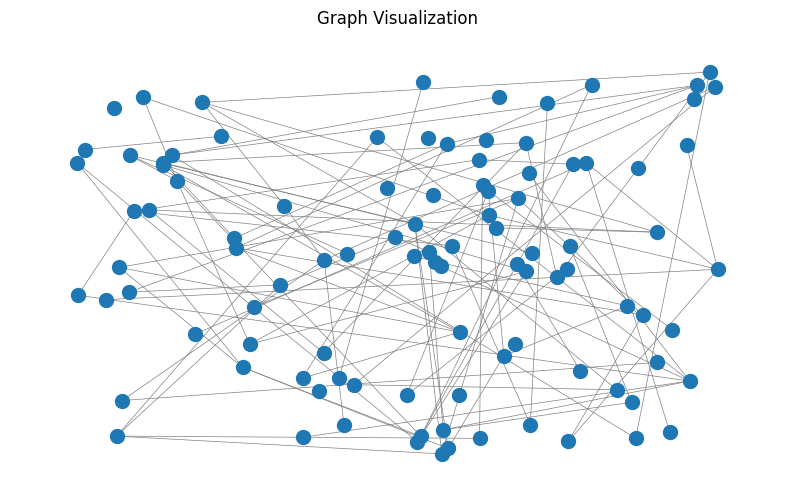

In [36]:
# Plot the graph
# Project 3D positions onto 2D plane
pos_2d = {node: (position[0], position[1]) for node, position in nx.get_node_attributes(G, 'position').items()}

plt.figure(figsize=(10, 6))
nx.draw_networkx(G, pos=pos_2d, with_labels=False, node_size=100, edge_color='gray', width=0.5)
plt.title("Graph Visualization")
plt.axis('off')
plt.show()

In [12]:
# extract features from the graph in our case position
features = []
for node, data in G.nodes(data=True):
    pos = data['position']
    features.append(pos)
    
features = np.array(features)

# print(features)

In [13]:
# identify best number of cluster for Kmeans
sil_score_max = -1 #this is the minimum possible score
n_clusters = 1

for cal_clusters in range(2,10):
    model = KMeans(n_clusters = cal_clusters, random_state=0, n_init='auto')
    labels = model.fit_predict(features)
    sil_score = silhouette_score(features, labels)
    print("The average silhouette score for %i clusters is %0.2f" %(cal_clusters,sil_score))
    if sil_score > sil_score_max:
        sil_score_max = sil_score
        n_clusters = cal_clusters
        
        
print("best number of cluster %i and score %0.2f" %(n_clusters, sil_score_max))

The average silhouette score for 2 clusters is 0.24
The average silhouette score for 3 clusters is 0.26
The average silhouette score for 4 clusters is 0.25
The average silhouette score for 5 clusters is 0.28
The average silhouette score for 6 clusters is 0.28
The average silhouette score for 7 clusters is 0.30
The average silhouette score for 8 clusters is 0.26
The average silhouette score for 9 clusters is 0.31
best number of cluster 9 and score 0.31


In [14]:
# apply K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(features)

# cluster labels
kMeans_labels = kmeans.labels_

# Assign the cluster labels to the nodes in the graph
for node, label in zip(G.nodes(), kMeans_labels):
    G.nodes[node]['KMeans'] = label

In [15]:
# identify best number of cluster agglomerative
sil_score_max = -1 #this is the minimum possible score
n_clusters = 1

for cal_clusters in range(2,10):
    model = AgglomerativeClustering(n_clusters = cal_clusters)
    labels = model.fit_predict(features)
    sil_score = silhouette_score(features, labels)
    print("The average silhouette score for %i clusters is %0.2f" %(cal_clusters,sil_score))
    if sil_score > sil_score_max:
        sil_score_max = sil_score
        n_clusters = cal_clusters
        
        
print("best number of cluster %i and score %0.2f" %(n_clusters, sil_score_max))

The average silhouette score for 2 clusters is 0.24
The average silhouette score for 3 clusters is 0.23
The average silhouette score for 4 clusters is 0.25
The average silhouette score for 5 clusters is 0.24
The average silhouette score for 6 clusters is 0.26
The average silhouette score for 7 clusters is 0.29
The average silhouette score for 8 clusters is 0.28
The average silhouette score for 9 clusters is 0.28
best number of cluster 7 and score 0.29


In [16]:
# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(features)
aglo_labels = agg_clustering.labels_

# Assign the cluster labels to the nodes in the graph
for node, label in zip(G.nodes(), aglo_labels):
    G.nodes[node]['Agglomerative'] = label



2.161767542706531
DBSCAN has 4 clusters
4
[ 0  0  0  1  1 -1  0 -1  1  0 -1  0  0  0  0  0  2  0 -1  0  0  0  0 -1
  1  0  1  2  0  0  0  0 -1  2  0 -1 -1 -1  0  0  0 -1  2 -1  0  0  0  0
  0  0  0  0  0  0 -1 -1  0  0 -1  1  0 -1  0  0  0  0 -1  0  0  0  0  0
  2  0  0  0  0  0  1  1  0 -1  0  0  0  0 -1 -1 -1 -1  0 -1  0 -1 -1  0
  0 -1  0  1]


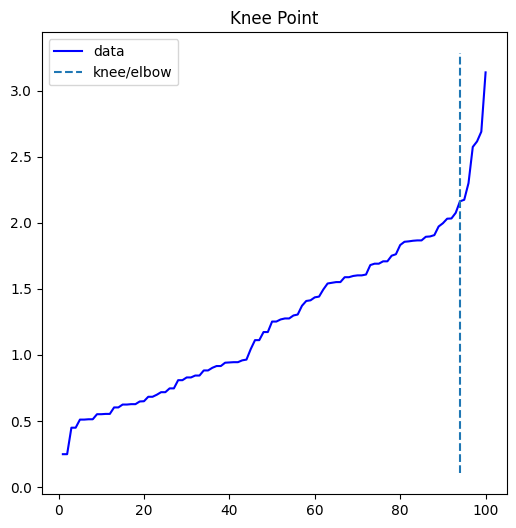

In [17]:
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(features)
distances, indices = nbrs.kneighbors(features)

distances = np.sort(distances, axis=0)
distances = distances[:,1]


kneedle = KneeLocator(range(1,len(distances)+1),  #x values
              distances, # y values
              S=1.0, #parameter suggested from paper
              curve="concave", #parameter from figure
              direction="increasing", #parameter from figure
              online=True
             )

kneedle.plot_knee()
print(kneedle.knee_y)

epsilon = kneedle.knee_y

dbscan_model = DBSCAN(eps=epsilon, min_samples=5)
dbscan_model.fit(features)

db_labels= dbscan_model.labels_

clNum = len(set(dbscan_model.labels_))

print("DBSCAN has %i clusters" %(clNum))

print(clNum)

print(db_labels)
    
# Assign the cluster labels to the nodes in the graph
for node, label in zip(G.nodes(), db_labels):
    G.nodes[node]['DBSCAN'] = label

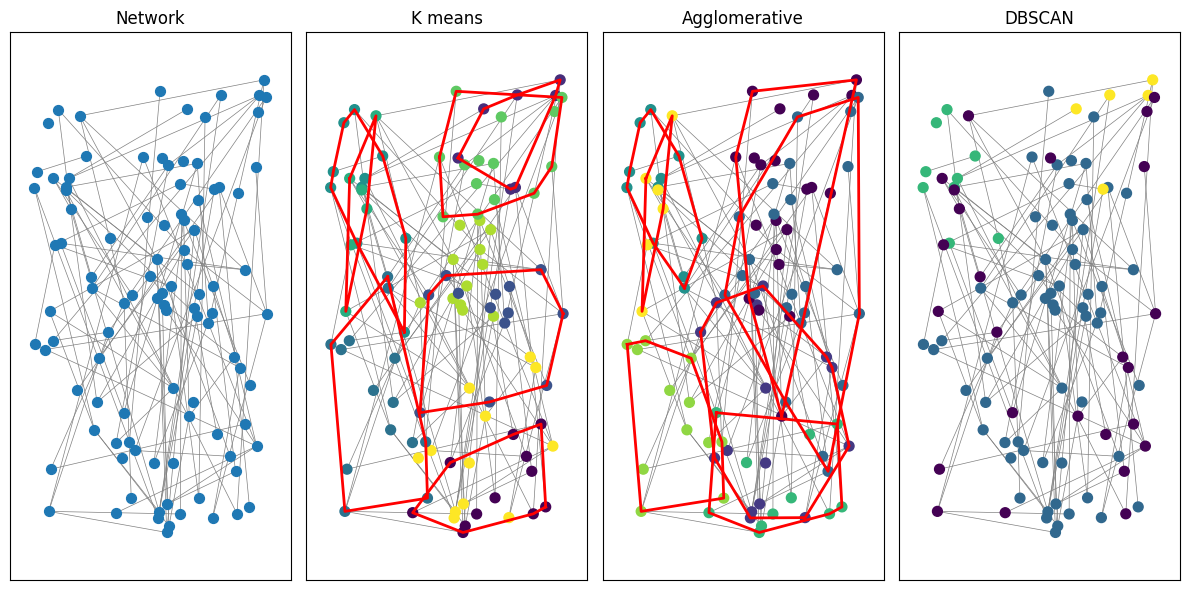

In [24]:
# Project 3D positions onto 2D plane
pos_2d = {node: (position[0], position[1]) for node, position in nx.get_node_attributes(G, 'position').items()}

# Create a 3D plot
fig = plt.figure(figsize=(12, 6))

# Plot the network without cluster coloring
ax1 = fig.add_subplot(141)
nx.draw_networkx(G, pos=pos_2d, with_labels=False, node_size=50, edge_color='gray', width=0.5, ax=ax1)
ax1.set_title('Network')

# Plot the network with color-coded clusters
ax2 = fig.add_subplot(142)
nx.draw_networkx(G, pos=pos_2d, node_color=kMeans_labels, cmap='viridis', with_labels=False, node_size=50, edge_color='gray', width=0.5, ax=ax2)
ax2.set_title('K means')

# create points based on the clusters
pointsClusters = [features[kMeans_labels == i, :2] for i in range(n_clusters)]

# apply convex hull
for (index, point) in enumerate(pointsClusters):
    hull = ConvexHull(point)
    hull_points = point[hull.vertices, :2]
    # Append the first vertex at the end of hull_points
    hull_points = np.append(hull_points, [hull_points[0]], axis=0)
    ax2.plot(hull_points[:, 0], hull_points[:, 1], 'r-', linewidth=2)

# Plot the network with color-coded clusters
ax3 = fig.add_subplot(143)
nx.draw_networkx(G, pos=pos_2d, node_color=aglo_labels, cmap='viridis', with_labels=False, node_size=50, edge_color='gray', width=0.5, ax=ax3)
ax3.set_title('Agglomerative')

# create points based on the clusters
pointsClusters = [features[aglo_labels == i, :2] for i in range(n_clusters)]
# apply convex hull
for (index, point) in enumerate(pointsClusters):
    hull = ConvexHull(point)
    hull_points = point[hull.vertices, :2]
    # Append the first vertex at the end of hull_points
    hull_points = np.append(hull_points, [hull_points[0]], axis=0)
    ax3.plot(hull_points[:, 0], hull_points[:, 1], 'r-', linewidth=2)

# Plot the network with color-coded clusters
ax4 = fig.add_subplot(144)
nx.draw_networkx(G, pos=pos_2d, node_color=db_labels, cmap='viridis', with_labels=False, node_size=50, edge_color='gray', width=0.5, ax=ax4)
ax4.set_title('DBSCAN')

# # create points based on the clusters
# pointsClusters = [features[db_labels == i, :2] for i in range(clNum)]
# # print(pointsClusters)
# # apply convex hull
# for (index, point) in enumerate(pointsClusters):
#     hull = ConvexHull(point)
#     hull_points = point[hull.vertices, :2]
#     # Append the first vertex at the end of hull_points
#     hull_points = np.append(hull_points, [hull_points[0]], axis=0)
#     ax3.plot(hull_points[:, 0], hull_points[:, 1], 'r-', linewidth=2)

plt.tight_layout()
plt.show()

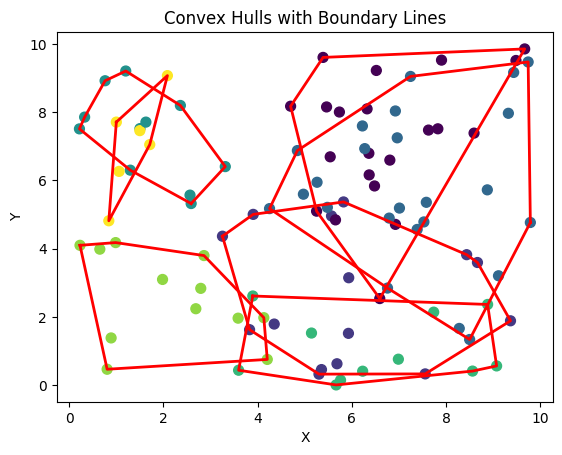

In [39]:
# Create a 2D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the points
ax.scatter(features[:, 0], features[:, 1], c=aglo_labels, cmap='viridis', s=50)


# apply convex hull
for (index, point) in enumerate(pointsClusters):
    hull = ConvexHull(point)
    hull_points = point[hull.vertices, :2]
    # Append the first vertex at the end of hull_points
    hull_points = np.append(hull_points, [hull_points[0]], axis=0)
    ax.plot(hull_points[:, 0], hull_points[:, 1], 'r-', linewidth=2)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Convex Hulls with Boundary Lines')

plt.show()




In [49]:
graph_data = {
    'nodes': [],
    'edges': []
}
for node, data in G.nodes(data=True):
    node_data = {
        'id': node,
        'position': data['position'],
        'Kmeans': int(data['KMeans']),
        'Agglo': int(data['Agglomerative'])
    }
    graph_data['nodes'].append(node_data)
    
for source, target, data in G.edges(data=True):
    source_position = graph_data['nodes'][source]['position']
    target_position = graph_data['nodes'][target]['position']
    
    edge_data = {
        'source': source,
        'target': target,
        'source_position': source_position,
        'target_position': target_position
    }
    graph_data['edges'].append(edge_data)

In [50]:
# Export the graph data to JSON file
with open('data/graph_clusters_{}.json'.format(num_nodes), 'w') as f:
    json.dump(graph_data, f, indent=4)